# Testing Stable Baselines3 with gym-MiniGrid

## Basic Jupyter Setting

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Setup the Colab environment (if used over Google Colab)

In [ ]:
# @title Install dependencies
!pip install rarfile --quiet
!pip install stable-baselines3 > /dev/null
!pip install box2d-py > /dev/null
!pip install gym gym-minigrid pyvirtualdisplay > /dev/null 2>&1
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

## Import Stable-Baselines3 and initial set-up

Import libraries and classes:

In [3]:
# Imports
import time
import io
import os
import glob
import torch
import base64
import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import PPO, DQN, A2C
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env

import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper, RGBImgPartialObsWrapper

Define the video function:

In [3]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


Define the rendering wrappers:

In [5]:
from gym.wrappers import Monitor

# Monitor is a gym wrapper, which helps easy rendering of videos of the wrapped environment.
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name):
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

## Test CNNPolicy

In [4]:
# By default, we use a DummyVecEnv as it is usually faster (cf doc)
num_cpu = 16  # Number of processes to use
env_id = 'MiniGrid-Empty-6x6-v0'

vec_env = ImgObsWrapper(RGBImgPartialObsWrapper(gym.make(env_id)))

obs = vec_env.reset()
print('Observation:', obs, ', Observation Shape: ', obs.shape)

# multivect model
#model_cnn = A2C('CnnPolicy', env=vec_env, verbose=1)

Observation: [[[146 146 146]
  [146 146 146]
  [146 146 146]
  ...
  [146 146 146]
  [146 146 146]
  [146 146 146]]

 [[146 146 146]
  [146 146 146]
  [146 146 146]
  ...
  [146 146 146]
  [146 146 146]
  [146 146 146]]

 [[146 146 146]
  [146 146 146]
  [146 146 146]
  ...
  [146 146 146]
  [146 146 146]
  [146 146 146]]

 ...

 [[146 146 146]
  [146 146 146]
  [146 146 146]
  ...
  [ 76  76  76]
  [ 76  76  76]
  [ 76  76  76]]

 [[146 146 146]
  [146 146 146]
  [146 146 146]
  ...
  [ 76  76  76]
  [ 76  76  76]
  [ 76  76  76]]

 [[146 146 146]
  [146 146 146]
  [146 146 146]
  ...
  [ 76  76  76]
  [ 76  76  76]
  [ 76  76  76]]] , Observation Shape:  (56, 56, 3)


In [51]:
from stable_baselines3.common.env_checker import check_env

check_env(vec_env)

/Users/inigo/Documents/cursos/Data Science/master_viu/work/minigrid/stable-baselines3/stable_baselines3/common/env_checker.py:48: UserWarning: The minimal resolution for an image is 36x36 for the default `CnnPolicy`. You might need to use a custom feature extractor cf. https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
  "The minimal resolution for an image is 36x36 for the default `CnnPolicy`. "


## Multi-processing vs Single-processing on A2C

Create a vectorized environment, specifying the wrapper class:

In [6]:
# By default, we use a DummyVecEnv as it is usually faster (cf doc)
num_cpu = 16  # Number of processes to use
env_id = 'MiniGrid-Empty-6x6-v0'

vec_env = make_vec_env(env_id, n_envs=num_cpu, wrapper_class=FlatObsWrapper)

# multivect model
model = A2C('MlpPolicy', env=vec_env, verbose=0)

Evaluate the model before training:

In [84]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.0 +/- 0.00


Define number of time steps for testing:

In [154]:
n_timesteps = 25000

### Single-process training

Create a single process wrapped environment and train the agent:

In [103]:
# Single Process RL Training
env = FlatObsWrapper(gym.make(env_id))
single_process_model = A2C('MlpPolicy', env=env, verbose=0)

start_time = time.time()
single_process_model.learn(n_timesteps)
total_time_single = time.time() - start_time

print(f"Took {total_time_single:.2f}s for single process version - {n_timesteps / total_time_single:.2f} FPS")

Took 38.12s for single process version - 655.86 FPS


Evaluate the trained agent over a separate environment:

In [104]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id))

# Agent after training
mean_reward, std_reward = evaluate_policy(single_process_model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.9375 +/- 0.00


### Multi-process RL training

Train the model on a multi-vectorized environment:

In [113]:
# Multiprocessed RL Training
start_time = time.time()
model.learn(n_timesteps)
total_time_multi = time.time() - start_time

print(f"Took {total_time_multi:.2f}s for multiprocessed version - {n_timesteps / total_time_multi:.2f} FPS")

Took 10.25s for multiprocessed version - 2439.55 FPS


Evaluate the model:

In [115]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.956250011920929 +/- 0.00


## Test training with stable baselines3 PPO

Create a multi-vectorized environment:

In [7]:
# By default, we use a DummyVecEnv as it is usually faster (cf doc)
num_cpu = 16  # Number of processes to use
env_id = 'MiniGrid-Empty-16x16-v0'
vec_env = make_vec_env(env_id, n_envs=num_cpu, wrapper_class=FlatObsWrapper)

Define hyperparameters matching the torch-ac settings:

In [29]:
#nn_layers = [64,64] #This is the configuration of your neural network. Currently, we have two layers, each consisting of 64 neurons.
                    #If you want three layers with 64 neurons each, set the value to [64,64,64] and so on.

#learning_rate = 0.001 #This is the step-size with which the gradient descent is carried out.
                      #Tip: Use smaller step-sizes for larger networks.
learning_rate = 0.00005
n_steps = 256
batch_size = 16
ent_coef = 0.001
n_epochs = 4
#policy_kwargs = dict(activation_fn=torch.nn.ReLU,net_arch=nn_layers)

Create the model and define the tensorboard log directory:

In [30]:
tensorboard_log = "./tmp/log/"
os.makedirs(tensorboard_log, exist_ok=True)
# Reset the environment
vec_env.reset()

# create the model
model = PPO('MlpPolicy', env=vec_env, learning_rate=learning_rate, batch_size=batch_size, ent_coef=ent_coef, n_epochs=n_epochs, n_steps=n_steps, tensorboard_log=tensorboard_log, verbose=1)

Using cpu device


Define the callback for the model evaluation while training

In [31]:
log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create eval environment
env = gym.make(env_id)
env = FlatObsWrapper(env)
env = stable_baselines3.common.monitor.Monitor(env, log_dir)
# Reset the environment
env.reset();
#For evaluating the performance of the agent periodically and logging the results.
callback = EvalCallback(env, log_path = log_dir, deterministic=True)

Train the model:

In [32]:
total_timesteps = 100000
log_interval = 1
tb_log_name = env_id

model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name = tb_log_name,
            callback=callback)
# The performance of the training will be printed every 10 episodes. Change it to 1, if you wish to
# view the performance at every training episode.

Logging to ./tmp/log/MiniGrid-Empty-16x16-v0_1
-----------------------------
| time/              |      |
|    fps             | 2658 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 4096 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1199         |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0048813066 |
|    clip_fraction        | 0.00922      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.94        |
|    explained_variance   | -3.84        |
|    learning_rate        | 5e-05        |
|    loss                 | -0.00455     |
|    n_updates            | 4            |
|    policy_gradient_loss | -0.0044      |
|    value_loss           | 0.0154       |
------------

Save the trained model:

In [36]:
# Save the agent
model.save(env_id)

In [8]:
model = PPO.load(path=env_id)

Evaluate the trained model:

In [10]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.975390613079071 +/- 0.00


Evaluate the trained model over a different environment:

In [21]:
env_id = 'MiniGrid-Empty-Random-6x6-v0'
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.9322500038146972 +/- 0.03


Check environment render:

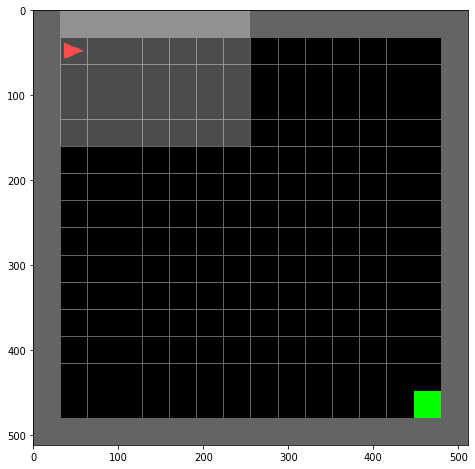

In [54]:
env_id = 'MiniGrid-Empty-16x16-v0'
eval_env = gym.make(env_id)
eval_env.reset()
before_img = eval_env.render('rgb_array')

plt.imshow(before_img);

Check observation tensor shape:

In [22]:
env_id = 'MiniGrid-Empty-16x16-v0'
#env = PyTorchObsWrapper(gym.make(env_id)) # Observation Shape:  (3, 80, 60)
#env = wrap_env(gym.make(env_id)) # Observation Shape:  (60, 80, 3)
#env = gym.make(env_id) # Observation Shape:  (60, 80, 3)
env = gen_wrapped_env(env_id) # Observation Shape:  (3, 80, 60)
            
#env = gym.make(env_id)
obs = env.reset()
print('Observation:', obs, ', Observation Shape: ', obs.shape)

# Select the action right
#action = env.actions.turn_right

# Take a step in the environment and store it in appropriate variables
#obs, reward, done, info = env.step(action)

#obs = obs.transpose(0,2,1)
#print('Observation:', obs, ', Observation Shape: ', obs.shape)

Observation: [2. 5. 0. ... 0. 0. 0.] , Observation Shape:  (2739,)


Run the model prediction and visualize video:

In [27]:
env_id = 'MiniGrid-Empty-16x16-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'

test_env = gen_wrapped_env(env_id)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0.975390625
Total length: 28


## Train, stop and resume with another environment

### First stage training
Let's have a quick look at the environment:

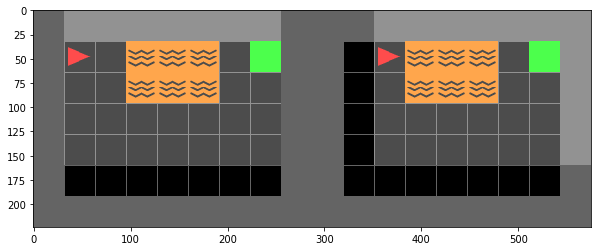

In [6]:
env = gym.make('MiniGrid-DistShift1-v0')
env.reset()
before_img = env.render('rgb_array')
action = env.actions.forward
obs, reward, done, info = env.step(action)
after_img = env.render('rgb_array')

plt.imshow(np.concatenate([before_img, after_img], 1));

Define and create the model to train:

In [29]:
# By default, we use a DummyVecEnv as it is usually faster (cf doc)
num_cpu = 16  # Number of processes to use
env_id = 'MiniGrid-DistShift1-v0'
vec_env = make_vec_env(env_id, n_envs=num_cpu, wrapper_class=FlatObsWrapper)

learning_rate = 0.00005
n_steps = 256
batch_size = 16
ent_coef = 0.001
n_epochs = 4

tensorboard_log = "./tmp/log/"
os.makedirs(tensorboard_log, exist_ok=True)
# Reset the environment
vec_env.reset()

# create the model
model = PPO('MlpPolicy',
            env=vec_env,
            learning_rate=learning_rate,
            batch_size=batch_size,
            ent_coef=ent_coef,
            n_epochs=n_epochs,
            n_steps=n_steps,
            tensorboard_log=tensorboard_log,
            verbose=1)

Using cpu device


Configure the monitor callback. It will output eval results on the Tensorboard 'eval' section:

In [30]:
log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create eval environment
env = gym.make(env_id)
env = FlatObsWrapper(env)
env = stable_baselines3.common.monitor.Monitor(env, log_dir)
# Reset the environment
env.reset();
#For evaluating the performance of the agent periodically and logging the results.
callback = EvalCallback(env, log_path = log_dir, deterministic=True)

Train the model on a first stage. It outputs log results on Tensorboard rollout section:

In [31]:
total_timesteps = 500000
log_interval = 10
tb_log_name = env_id

model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name = tb_log_name,
            callback=callback)
# The performance of the training will be printed every 10 episodes. Change it to 1, if you wish to
# view the performance at every training episode.

Logging to ./tmp/log/MiniGrid-DistShift1-v0_1
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.02        |
|    ep_rew_mean          | 0           |
| time/                   |             |
|    fps                  | 844         |
|    iterations           | 10          |
|    time_elapsed         | 48          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.046871115 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.15       |
|    explained_variance   | -22.3       |
|    learning_rate        | 5e-05       |
|    loss                 | 0.217       |
|    n_updates            | 36          |
|    policy_gradient_loss | -0.00899    |
|    value_loss           | 2.57e-05    |
-----------------------------------------
-----------------------------------------
| rollout/                |   

Save the model in case we close the notebook:

In [32]:
# Save the agent
model.save(env_id) 

Let's evaluate the model at this stage:

In [34]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.9535714387893677 +/- 0.00


### Second stage training
Reload the model and continue the learning process for some additional timesteps:

In [35]:
# number of timesteps to add
total_timesteps = 200000
log_interval = 10

# load the model on previous vectorized env and tensorboard log directory
model = PPO.load(path=env_id, env=vec_env, tensorboard_log=tensorboard_log)
#model.set_env(vec_env)

# resume training using same tensorboard run without resetting the timesteps
model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=False)

Logging to ./tmp/log/MiniGrid-DistShift1-v0_1
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 16.6        |
|    ep_rew_mean          | 0.941       |
| time/                   |             |
|    fps                  | 867         |
|    iterations           | 10          |
|    time_elapsed         | 47          |
|    total_timesteps      | 544768      |
| train/                  |             |
|    approx_kl            | 0.016715989 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.225      |
|    explained_variance   | 0.363       |
|    learning_rate        | 5e-05       |
|    loss                 | 0.0405      |
|    n_updates            | 528         |
|    policy_gradient_loss | -0.0104     |
|    value_loss           | 0.0025      |
-----------------------------------------
-----------------------------------------
| rollout/                |   

Let's evaluate again the model:

In [7]:
#model = PPO.load('MiniGrid-DistShift1-v0_2')

In [9]:
env_id = 'MiniGrid-DistShift1-v0'
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.9535714387893677 +/- 0.00


Let's see mean reward with the second environment 'Minigrid-DistShift2-v0':

In [10]:
env_id = 'MiniGrid-DistShift2-v0'
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.0 +/- 0.00


Let's save again the model:

In [49]:
# Save the agent
model.save(env_id+'_2') 

Let's see the model prediction with the original environment:

In [85]:
# reload the model in case we don't have it
model = PPO.load('MiniGrid-DistShift1-v0_2')

env_id = 'MiniGrid-DistShift1-v0'

test_env = gen_wrapped_env(env_id)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0.9535714285714285
Total length: 13


Now let's see how it works with the second slightly different environment (which has not seen yet). It seems it doesn't perform very well:

In [86]:
# reload the model in case we don't have it
#model = PPO.load('MiniGrid-DistShift1-v0_2')

env_id = 'MiniGrid-DistShift2-v0'

test_env = gen_wrapped_env(env_id)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0
Total length: 252


### Simple Curriculum Learning
Now we do some Curriculum Learning, and keep training the model with the second environment. Let's create the new vectorized environment:

In [50]:
# By default, we use a DummyVecEnv as it is usually faster (cf doc)
num_cpu = 16  # Number of processes to use
new_env_id = 'MiniGrid-DistShift2-v0'
vec_env = make_vec_env(new_env_id, n_envs=num_cpu, wrapper_class=FlatObsWrapper)

Load the last saved trained model with the new environment:

In [51]:
# previous saved environment
prev_env_id = env_id + '_2'

# load the model on previous vectorized env and tensorboard log directory
model = PPO.load(path=prev_env_id, env=vec_env, tensorboard_log=tensorboard_log)
#model.set_env(vec_env)

Continue the training, but over the new environment:

In [52]:
# number of timesteps to add
total_timesteps = 500000
log_interval = 10

# resume training using same tensorboard run without resetting the timesteps
model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=False, 
            callback=callback)

Logging to ./tmp/log/MiniGrid-DistShift1-v0_1
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 22.1       |
|    ep_rew_mean          | 0.921      |
| time/                   |            |
|    fps                  | 778        |
|    iterations           | 10         |
|    time_elapsed         | 52         |
|    total_timesteps      | 745472     |
| train/                  |            |
|    approx_kl            | 0.02460795 |
|    clip_fraction        | 0.151      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.266     |
|    explained_variance   | 0.247      |
|    learning_rate        | 5e-05      |
|    loss                 | -0.0128    |
|    n_updates            | 724        |
|    policy_gradient_loss | -0.0139    |
|    value_loss           | 0.0094     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_l

Let's save the model at this point:

In [53]:
# Save the agent
new_env_id2 = 'MiniGrid-DistShift2_with_1-v0'
model.save(new_env_id2) 

We add some more few steps of training:

In [54]:
# uncomment to load the last saved model in case the notebook kernel is restarted
#model = PPO.load(path=new_env_id2, env=vec_env, tensorboard_log=tensorboard_log)

# number of timesteps to add
total_timesteps = 500000
log_interval = 10

# resume training using same tensorboard run without resetting the timesteps
model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=False, 
            callback=callback)

Logging to ./tmp/log/MiniGrid-DistShift1-v0_1
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 17.9        |
|    ep_rew_mean          | 0.936       |
| time/                   |             |
|    fps                  | 763         |
|    iterations           | 10          |
|    time_elapsed         | 53          |
|    total_timesteps      | 1249280     |
| train/                  |             |
|    approx_kl            | 0.038906373 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.118      |
|    explained_variance   | 0.852       |
|    learning_rate        | 5e-05       |
|    loss                 | -0.0115     |
|    n_updates            | 1216        |
|    policy_gradient_loss | 0.00679     |
|    value_loss           | 0.000273    |
-----------------------------------------
-----------------------------------------
| rollout/                |   

In [55]:
# Save the agent
new_env_id3 = 'MiniGrid-DistShift2_with_1-v0_2'
model.save(new_env_id3) 

Let's try now the performance on the new environment 'MiniGrid-DistShift2-v0':

In [72]:
# uncomment to load the last saved model in case the notebook kernel is restarted, etc.
model = PPO.load(path=new_env_id3)

# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make('MiniGrid-DistShift2-v0'))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.9464285969734192 +/- 0.00


And now, let's try also with the first environment 'MiniGrid-DistShift1-v0' to see what happens:

In [88]:
# uncomment to load the last saved model in case the notebook kernel is restarted, etc.
# model = PPO.load(path=new_env_id3)

# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make('MiniGrid-DistShift1-v0'))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.9464285969734192 +/- 0.00


Let's run the predict over the two environments and see how it goes now. We first try with the latest environment training 'MiniGrid-DistShift2-v0', it does solve it thought through a longer path:

In [89]:
model = PPO.load(path='MiniGrid-DistShift2_with_1-v0_2')

env_id = 'MiniGrid-DistShift2-v0'

test_env = gen_wrapped_env(env_id)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0.9464285714285714
Total length: 15


And now with the first learned environment 'MiniGrid-DistShift1-v0', where it changed its behaviour making a slightly longer run also:

In [90]:
env_id = 'MiniGrid-DistShift1-v0'

test_env = gen_wrapped_env(env_id)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0.9464285714285714
Total length: 15


## Curriculum learning

### Define the environments

In [41]:
# By default, we use a DummyVecEnv as it is usually faster (cf doc)
num_cpu = 16  # Number of processes to use
env_id_1 = 'MiniGrid-DoorKey-5x5-v0'
vec_env_1 = make_vec_env(env_id_1, n_envs=num_cpu, wrapper_class=FlatObsWrapper)

env_id_2 = 'MiniGrid-DoorKey-6x6-v0'
vec_env_2 = make_vec_env(env_id_2, n_envs=num_cpu, wrapper_class=FlatObsWrapper)

env_id_3 = 'MiniGrid-DoorKey-8x8-v0'
vec_env_3 = make_vec_env(env_id_3, n_envs=num_cpu, wrapper_class=FlatObsWrapper)

env_id_4 = 'MiniGrid-DoorKey-16x16-v0'
vec_env_4 = make_vec_env(env_id_4, n_envs=num_cpu, wrapper_class=FlatObsWrapper)

In [42]:
learning_rate = 0.00005
n_steps = 256
batch_size = 16
ent_coef = 0.001
n_epochs = 4

tensorboard_log = "./tmp/log/"
os.makedirs(tensorboard_log, exist_ok=True)

tb_log_name = 'Curriculum-Doorkey'

In [43]:
# Reset the environment
vec_env_1.reset()

# create the model
model = PPO('MlpPolicy',
            env=vec_env_1,
            learning_rate=learning_rate,
            batch_size=batch_size,
            ent_coef=ent_coef,
            n_epochs=n_epochs,
            n_steps=n_steps,
            tensorboard_log=tensorboard_log,
            verbose=1)

Using cpu device


In [45]:
log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create eval environment
env = gym.make(env_id_1)
env = FlatObsWrapper(env)
eval_env = stable_baselines3.common.monitor.Monitor(env, log_dir)
# Reset the environment
eval_env.reset();
# Stop training when the model reaches the reward threshold
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=0.90, verbose=1)
eval_callback = EvalCallback(eval_env, log_path=log_dir, callback_on_new_best=callback_on_best, verbose=1)

In [46]:
total_timesteps = 500000
log_interval = 10

model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name = tb_log_name,
            callback=eval_callback)

Logging to ./tmp/log/Curriculum-Doorkey_1
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 222          |
|    ep_rew_mean          | 0.131        |
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 10           |
|    time_elapsed         | 50           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0062883142 |
|    clip_fraction        | 0.0204       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.8         |
|    explained_variance   | 0.4          |
|    learning_rate        | 5e-05        |
|    loss                 | 0.00072      |
|    n_updates            | 36           |
|    policy_gradient_loss | -0.00405     |
|    value_loss           | 0.00368      |
------------------------------------------
-----------------------------------------
| rollout/   

In [50]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_1))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.8846479868888855 +/- 0.26


In [63]:
env_id = env_id_1

test_env = gen_wrapped_env(env_id)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0.9604
Total length: 11


In [64]:
# Save the agent
model.save(env_id_1)

In [72]:
model.set_env(vec_env_2)

In [73]:
# Create eval environment
env = gym.make(env_id_2)
env = FlatObsWrapper(env)
eval_env = stable_baselines3.common.monitor.Monitor(env, log_dir)
# Reset the environment
eval_env.reset();
# Stop training when the model reaches the reward threshold
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=0.90, verbose=1)
eval_callback = EvalCallback(eval_env, log_path=log_dir, callback_on_new_best=callback_on_best, verbose=1)

In [74]:
# number of timesteps to add
total_timesteps = 1000000
log_interval = 10

# resume training using same tensorboard run without resetting the timesteps
model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=False, 
            callback=eval_callback)

Logging to ./tmp/log/Curriculum-Doorkey_1
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 159         |
|    ep_rew_mean          | 0.573       |
| time/                   |             |
|    fps                  | 873         |
|    iterations           | 10          |
|    time_elapsed         | 46          |
|    total_timesteps      | 200960      |
| train/                  |             |
|    approx_kl            | 0.013858551 |
|    clip_fraction        | 0.0627      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.599      |
|    explained_variance   | 0.467       |
|    learning_rate        | 5e-05       |
|    loss                 | -0.0185     |
|    n_updates            | 192         |
|    policy_gradient_loss | -0.000816   |
|    value_loss           | 0.00367     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

In [75]:
# Save the agent
model.save(env_id_2)

In [76]:
model.set_env(vec_env_3)

# Create eval environment
env = gym.make(env_id_3)
env = FlatObsWrapper(env)
eval_env = stable_baselines3.common.monitor.Monitor(env, log_dir)
# Reset the environment
eval_env.reset();
# Stop training when the model reaches the reward threshold
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=0.90, verbose=1)
eval_callback = EvalCallback(eval_env, log_path=log_dir, callback_on_new_best=callback_on_best, verbose=1)

# number of timesteps to add
total_timesteps = 1000000
log_interval = 10

# resume training using same tensorboard run without resetting the timesteps
model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=False, 
            callback=eval_callback)

Logging to ./tmp/log/Curriculum-Doorkey_1
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 295         |
|    ep_rew_mean          | 0.557       |
| time/                   |             |
|    fps                  | 865         |
|    iterations           | 10          |
|    time_elapsed         | 47          |
|    total_timesteps      | 360960      |
| train/                  |             |
|    approx_kl            | 0.012058819 |
|    clip_fraction        | 0.0997      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.433      |
|    explained_variance   | 0.124       |
|    learning_rate        | 5e-05       |
|    loss                 | -0.0632     |
|    n_updates            | 348         |
|    policy_gradient_loss | 0.00335     |
|    value_loss           | 0.00184     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

In [77]:
# Save the agent
model.save(env_id_3)

In [90]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_3))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.9705250096321106 +/- 0.01


In [91]:
model.set_env(vec_env_4)

# Create eval environment
env = gym.make(env_id_4)
env = FlatObsWrapper(env)
eval_env = stable_baselines3.common.monitor.Monitor(env, log_dir)
# Reset the environment
eval_env.reset();
# Stop training when the model reaches the reward threshold
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=0.90, verbose=1)
eval_callback = EvalCallback(eval_env, log_path=log_dir, callback_on_new_best=callback_on_best, verbose=1)

# number of timesteps to add
total_timesteps = 1000000
log_interval = 10

# resume training using same tensorboard run without resetting the timesteps
model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=False, 
            callback=eval_callback)

Logging to ./tmp/log/Curriculum-Doorkey_1
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 347          |
|    ep_rew_mean          | 0.874        |
| time/                   |              |
|    fps                  | 828          |
|    iterations           | 10           |
|    time_elapsed         | 49           |
|    total_timesteps      | 520960       |
| train/                  |              |
|    approx_kl            | 0.0130156595 |
|    clip_fraction        | 0.104        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.342       |
|    explained_variance   | 0.358        |
|    learning_rate        | 5e-05        |
|    loss                 | -0.00808     |
|    n_updates            | 504          |
|    policy_gradient_loss | -0.00154     |
|    value_loss           | 0.00304      |
------------------------------------------
-----------------------------------------
| rollout/   

In [92]:
# Save the agent
model.save(env_id_4)

In [104]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_2))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.8295999944210053 +/- 0.33


In [141]:
env_id = env_id_4

test_env = gen_wrapped_env(env_id)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=False)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0.9708203125
Total length: 83


In [144]:
# Reset the environment
vec_env_4.reset()

# create the model
model = PPO('MlpPolicy',
            env=vec_env_4,
            learning_rate=learning_rate,
            batch_size=batch_size,
            ent_coef=ent_coef,
            n_epochs=n_epochs,
            n_steps=n_steps,
            tensorboard_log=tensorboard_log,
            verbose=1)

Using cpu device


In [145]:
# Create eval environment
env = gym.make(env_id_4)
env = FlatObsWrapper(env)
eval_env = stable_baselines3.common.monitor.Monitor(env, log_dir)
# Reset the environment
eval_env.reset();
# Stop training when the model reaches the reward threshold
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=0.90, verbose=1)
eval_callback = EvalCallback(eval_env, log_path=log_dir, callback_on_new_best=callback_on_best, verbose=1)

# number of timesteps to add
total_timesteps = 1000000
log_interval = 10
tb_log_name = 'Doorkey-16x16'

# resume training using same tensorboard run without resetting the timesteps
model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name = tb_log_name)

Logging to ./tmp/log/Doorkey-16x16_1
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.56e+03    |
|    ep_rew_mean          | 0           |
| time/                   |             |
|    fps                  | 789         |
|    iterations           | 10          |
|    time_elapsed         | 51          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.005105094 |
|    clip_fraction        | 0.00696     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.92       |
|    explained_variance   | -2.82       |
|    learning_rate        | 5e-05       |
|    loss                 | -0.0163     |
|    n_updates            | 36          |
|    policy_gradient_loss | -0.00385    |
|    value_loss           | 0.000182    |
-----------------------------------------
-----------------------------------------
| rollout/                |            

In [146]:
# Save the agent
model.save('MiniGrid-DoorKey-16x16-v0_no_curr')

In [147]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_4))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

/Users/inigo/Documents/cursos/Data Science/master_viu/work/minigrid/stable-baselines3/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Mean reward: 0.0 +/- 0.00


In [148]:
env_id = env_id_4

test_env = gen_wrapped_env(env_id)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=False)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0
Total length: 2560


## SNIPPETS y PRUEBAS VARIAS

In [45]:
nn_layers = [64,64] #This is the configuration of your neural network. Currently, we have two layers, each consisting of 64 neurons.
                    #If you want three layers with 64 neurons each, set the value to [64,64,64] and so on.

learning_rate = 0.001 #This is the step-size with which the gradient descent is carried out.
                      #Tip: Use smaller step-sizes for larger networks.

In [46]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
#env = gym.make('LunarLander-v2')
# Make a new environment MiniGrid-Empty-8x8-v0
#env = gym.make('MiniGrid-DoorKey-5x5-v0')
#env = gym.make('MiniGrid-Empty-8x8-v0')
env = gym.make('MiniGrid-FourRooms-v0')
env = FlatObsWrapper(env)

#env = FlatObsWrapper(gym_minigrid.wrappers.ImgObsWrapper(gym_minigrid.wrappers.RGBImgObsWrapper(env)))
# Reset the environment
env.reset();

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

callback = EvalCallback(env,log_path = log_dir, deterministic=True) #For evaluating the performance of the agent periodically and logging the results.
#policy_kwargs = dict(activation_fn=torch.nn.ReLU,net_arch=nn_layers)
 
model = PPO("MlpPolicy", env, learning_rate=learning_rate) 

# You can also experiment with other RL algorithms like A2C, PPO, DDPG etc. Refer to  https://stable-baselines3.readthedocs.io/en/master/guide/examples.html
#for documentation. For example, if you would like to run DDPG, just replace "DQN" above with "DDPG".

In [ ]:
#test_env = wrap_env(gym.make('MiniGrid-Empty-8x8-v0'))
#test_env = gen_wrapped_env('MiniGrid-DoorKey-5x5-v0')
#test_env = gen_wrapped_env('MiniGrid-Empty-8x8-v0')
test_env = gen_wrapped_env('MiniGrid-FourRooms-v0')

observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0
Total length: 100


In [ ]:
total_timesteps = 1000000
log_interval = 10

model.learn(total_timesteps=total_timesteps, log_interval=log_interval, callback=callback)
# The performance of the training will be printed every 10 episodes. Change it to 1, if you wish to
# view the performance at every training episode.

Eval num_timesteps=10000, episode_reward=0.00 +/- 0.00
Episode length: 100.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=0.00 +/- 0.00
Episode length: 100.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=0.00 +/- 0.00
Episode length: 100.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=0.00 +/- 0.00
Episode length: 100.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=0.00 +/- 0.00
Episode length: 100.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=0.00 +/- 0.00
Episode length: 100.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=0.00 +/- 0.00
Episode length: 100.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=0.00 +/- 0.00
Episode length: 100.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=0.00 +/- 0.00
Episode length: 100.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=0.00 +/- 0.00
Episode length: 100.00 +/- 0.00
Eval num_timesteps=110000, episode_reward=0.00 +/- 0.00
Episode length: 100.00 +/- 0.00
Eval num_timesteps=

In [ ]:
#env = gen_wrapped_env('MiniGrid-Empty-8x8-v0')
#env = gen_wrapped_env('MiniGrid-DoorKey-5x5-v0')
env = gen_wrapped_env('MiniGrid-FourRooms-v0')
observation = env.reset()

while True:
  #env.render()
  action, _states = model.predict(observation, deterministic=True)
  observation, reward, done, info = env.step(action)
  if done:
    break;

env.close()
show_video()